# Advanced Lane Finding Project #

The steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. With the camera calibration matrix, apply a distortion correction to raw images.
3. Use color transforms amd gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and apply polynomial regression to find the right and left lines of the lane boundary.This is not done for every image but used as a starting point or when left and right lanes are not detected on this frame.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Apply smoothing to draw consistent lines



The files included with this submission are :
1. AdvancedLandeFind.ipynb  - This Jupyter Notebook
2. AdvancedLandFind.md - A markdown version of this notebook
3. AdvancedLaneFind.html - A html version of this notebook
4. lane_find.py - The source code python functions used in this assignment and included in this notebook
5. result_project_out.mp4 - The output video embedded in html and notebooks of the project video
6. output_x.png - The output images illustrating distortion-correction, perspective transformations, thresholding images and overlaid result.

Let us walk through each of the above steps and then present the final outcome before we discuss how we might improve the project more :

In [1]:
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## 1, 2 Compute Calibration ##

Cameras do not capture a 3D object's size, shape, appearance or distance correctly. The captured image suffers from radial and tangential distortion. In order to correct this distortion we compute the distortion matrix and associated parameters necessary to apply a distortion correction to the image. To compute these we col lect the 3-D object-points (objpoints) of chessboard corners and corresponding image points of the calibration chessboard images. We inspected the chess-board images, saw they were 9x6 and leveraged cv2 library's findChessboardCorners to detect the corners on the images. If the corners were detected successfully (they were not for 3 of the images) we used cv2.Calibrate camera to compute the distortion matrix and parameters.

Armed with the calibration parameters, we are able to apply cv2.undistort_image to undistort the image. A sample undistortion is demonstrated below.

In [2]:


def calibrate_camera(image_shape):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        #else:
            #print("Corners not found for", fname)

    img_size = (image_shape[1], image_shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration result for later use (we won't worry about
    # rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open("camera_dist_pickle.p", "wb"))

    return

In [3]:
'''
Initializations for Camera Calibration
'''
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

calibrate_camera(img.shape)
dist_pickle = pickle.load(open("camera_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

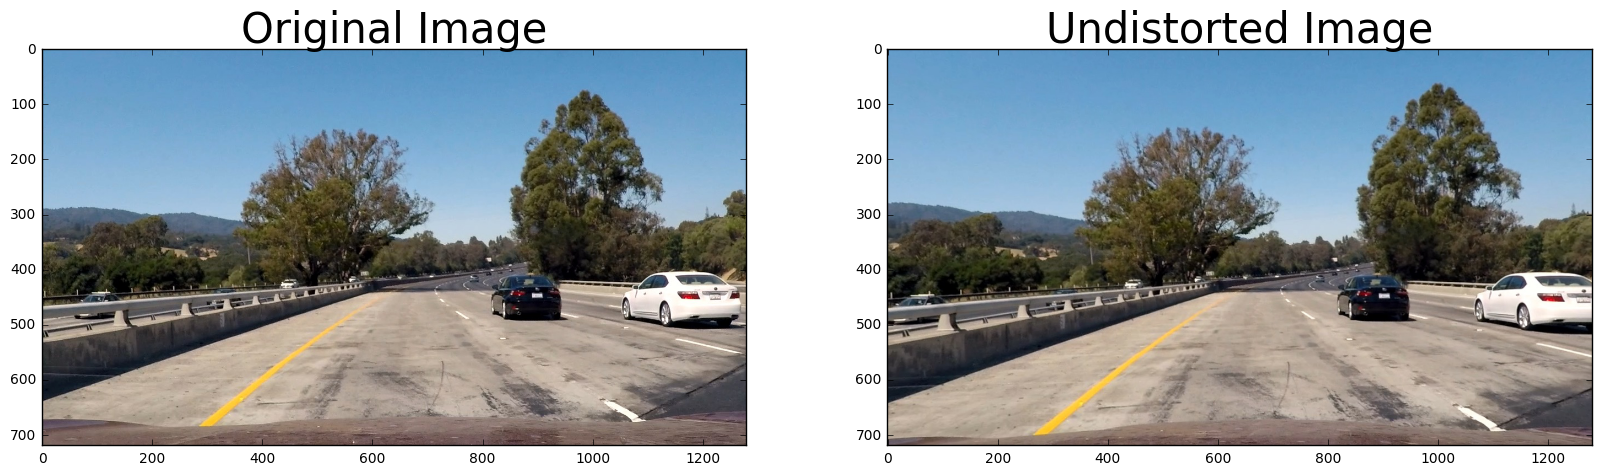

In [4]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


%matplotlib inline
undistorted_image = undistort_image(img, mtx, dist)
#dst_copy = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)


## 3 Create Thresholded Binary Image ##

This was done by a combination of gradient and color thresholds in our function threshold_pipeline below. 

The gradient threshold in the x-direction was done by applying the scaled Sobel X operator as it helps detect vertical lines better. 

The color threshold's goal is to detect both the yellow and white lines. First I converted the RGB image to HSV image. Of the different components the S with the thresholds specified from the lecture notes captured the yellow and white lines irrespective of the different shadow and lighting conditions. 

I then combined the gradient and color thresholds and created a binary image as shown below - 

In [5]:
def threshold_pipeline(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    img = np.copy(img)

    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:, :, 0]
    l_channel = hsv[:, :, 1]
    s_channel = hsv[:, :, 2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what
    # might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) &
             (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can
    # see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

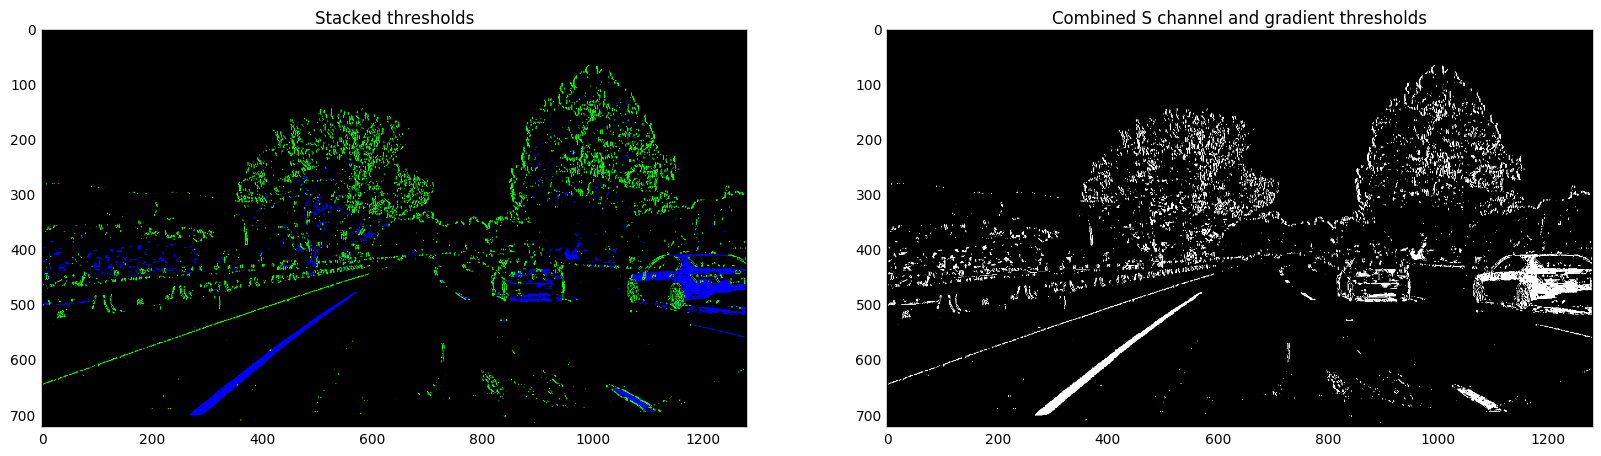

In [6]:
color_binary, combined_binary = threshold_pipeline(undistorted_image)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

## 4 Perspective transformation to Top-Down  ##

I compute the perspective matrix needed for the top-down perspective image of the lane-lines using compute_perspective_matrixes below.  This function takes as input a reference image (`test_images/straight_lines1.jpg`. I initally experimented with and hardcoded multiple source and destination points but in the sample write-up found a formulaic approach to selecting the source and destination points to compute source (`src`) and destination (`dst`) points. The resultant points matched very closely to one of my selections. The source and destination points were specified in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified the top-down perspective transform worked properly by  inspecting the image and its warped counterpart to verify that the lines appear parallel in the warped image below.

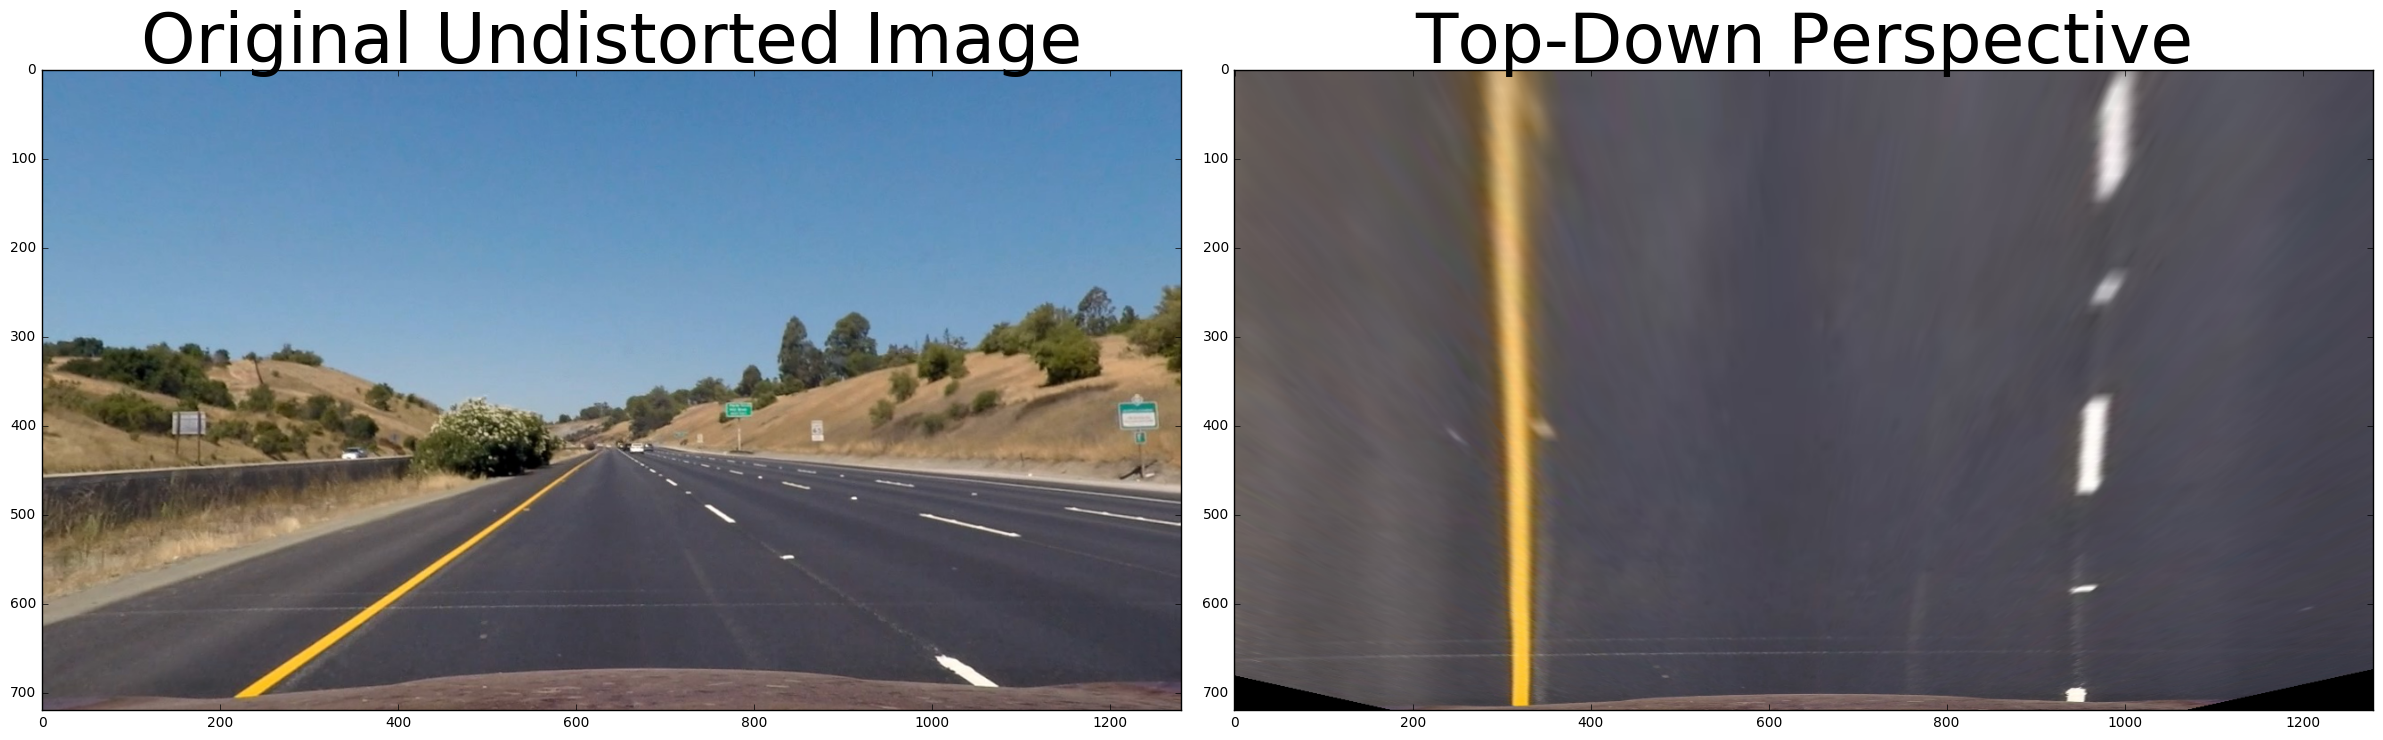

In [7]:
# Compute the Perspective Matrix
def compute_perspective_matrixes(straight_line_img_name):
    img_straight = cv2.imread(straight_line_img_name)
    img_size = (img_straight.shape[1], img_straight.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

M, Minv = compute_perspective_matrixes('test_images/straight_lines1.jpg')

def warp_binary_image(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

img_straight = cv2.imread('test_images/straight_lines1.jpg')
img_straight = cv2.cvtColor(img_straight, cv2.COLOR_BGR2RGB)
undistorted_straight_line = undistort_image(img_straight, mtx, dist)
warped_line = warp_binary_image(undistorted_straight_line, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_straight_line)
ax1.set_title('Original Undistorted Image', fontsize=50)
ax2.imshow(warped_line)
ax2.set_title('Top-Down Perspective', fontsize=50)

## Image Pre-processing - Putting the above steps together  ##

The following images show an original test image and by its side an undistorted, thresholded, top-down image with the lanes lines. We will subsequently trace out the lane lines from the binary_warped image.

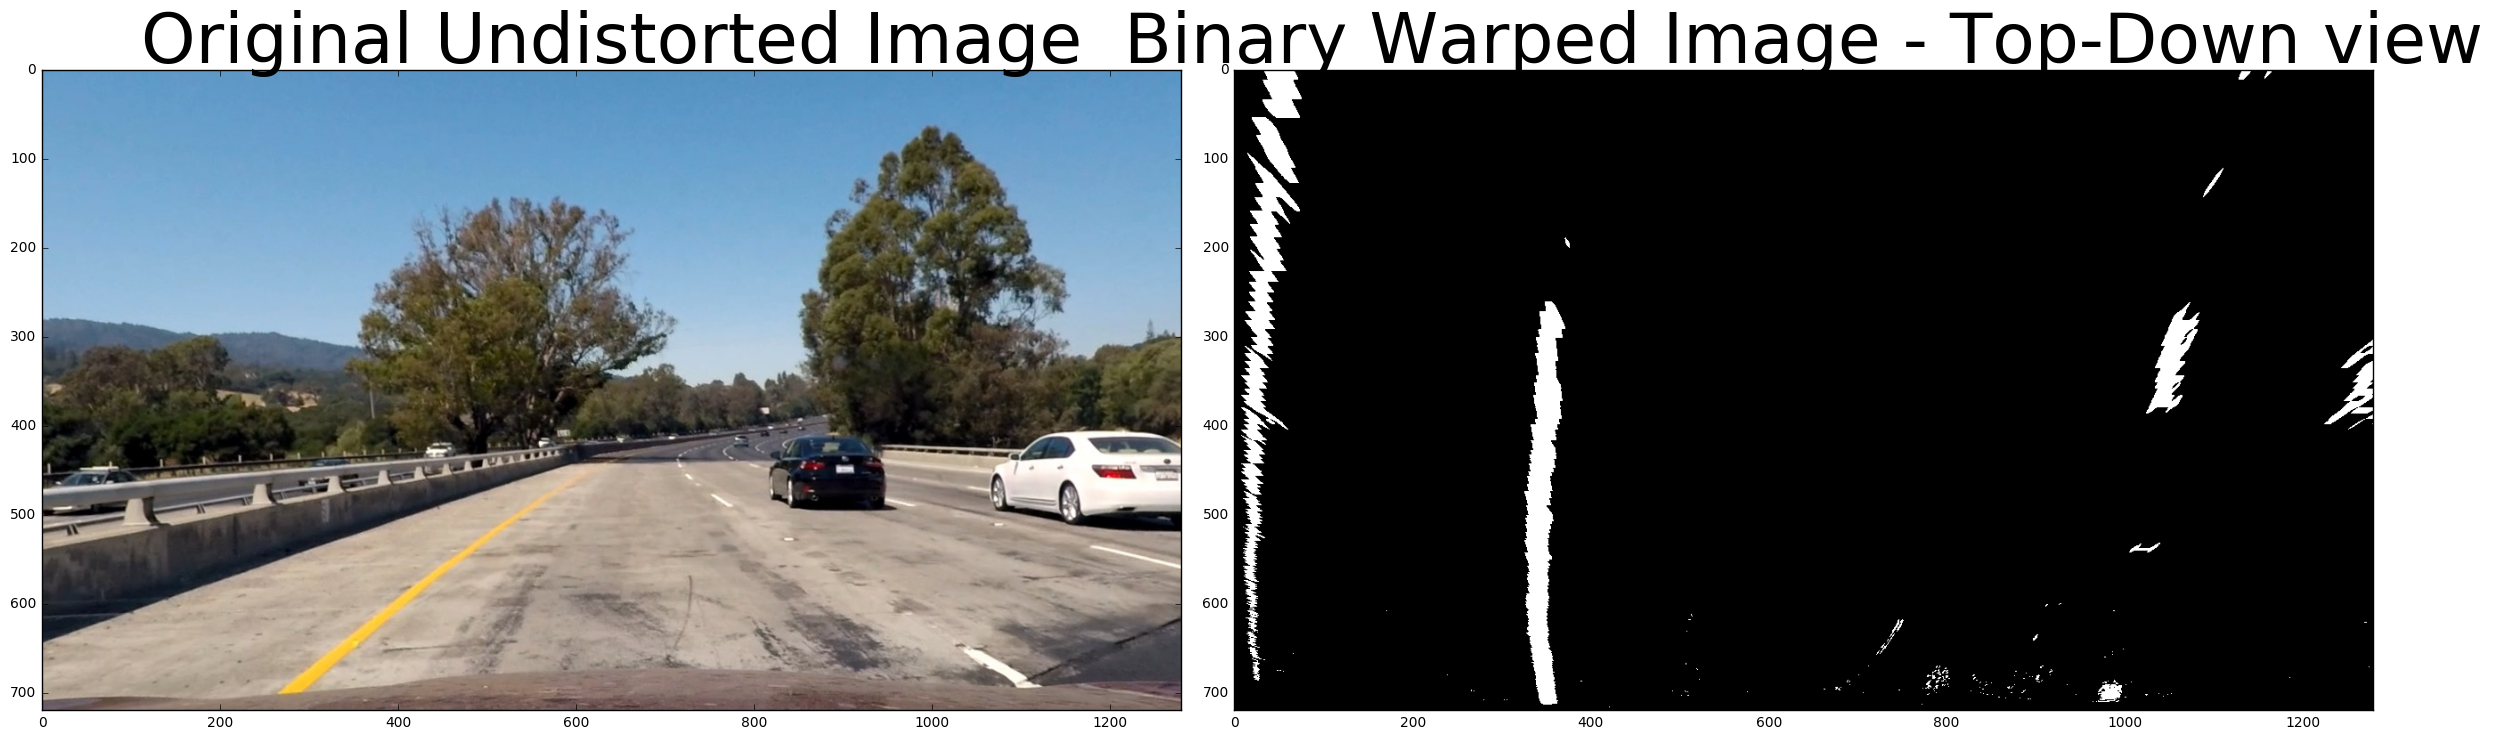

In [8]:
def pre_process_image(img, M, mtx, dist):

    # Undistort Image
    undist = undistort_image(img, mtx, dist)

    # Create binary image
    color_binary, combined_binary = threshold_pipeline(undist)

    # Apply perspective transform
    binary_warped = warp_binary_image(combined_binary, M)

    return binary_warped

binary_warped = pre_process_image(img, M, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_image)
ax1.set_title('Original Undistorted Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped Image - Top-Down view', fontsize=50)

## 5 Lane Pixel Detection and Drawing ##

Now that we a thresholded warped image we will map out the lane lines. 

**Lane Line Detection**
We will find which pixels are part of the lane lines which are not. In our function compute_left_and_right_fit we take a histogram (compute_land_hist_bases_and_midpoints) along all columns in the lower half of the image and then use the two peaks of the histogram  a starting point for the x-position of the base of the lines. 

Then centered on those starting points as base, using a sliding window approach we locate the pixels (red and blue dots in our image below)associated with the lane lines. A polynomial regression (in compute_left_and_right_fit) is then applied to these points to approximate the lane lines and drawn back on the image in yellow.

In [9]:
def compute_lane_hist_bases_and_midpoints(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(
        binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    
    #plt.plot(histogram)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

midpoint, leftx_base, rightx_base = compute_lane_hist_bases_and_midpoints(binary_warped)
#print(midpoint, leftx_base, rightx_base)

In [10]:
def compute_left_and_right_fit(binary_warped,
                               prev_left_fit=None, prev_right_fit=None,
                               redetect=True, doplot=False):

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40

    if redetect == True:
        midpoint, leftx_base, rightx_base = compute_lane_hist_bases_and_midpoints(
            binary_warped)

        # Choose the number of sliding windows
        nwindows = 9

        # Set height of windows
        window_height = np.int(binary_warped.shape[0] / nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Step through the windows one by one
        for window in range(nwindows):

            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
                nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (
                nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean
        # position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

    else:
        # Do not do a blind search but use the previous fits to locate the pixels
        left_lane_inds = ((nonzerox > (prev_left_fit[0] * (nonzeroy**2) + prev_left_fit[1] * nonzeroy + prev_left_fit[2] - margin)) & (
            nonzerox < (prev_left_fit[0] * (nonzeroy**2) + prev_left_fit[1] * nonzeroy + prev_left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (prev_right_fit[0] * (nonzeroy**2) + prev_right_fit[1] * nonzeroy + prev_right_fit[2] - margin)) & (
            nonzerox < (prev_right_fit[0] * (nonzeroy**2) + prev_right_fit[1] * nonzeroy + prev_right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if (len(leftx) == 0) or (len(lefty) == 0):
        return None, None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # if we are asked to plot output
    if (doplot == True):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack(
            (binary_warped, binary_warped, binary_warped)) * 255
        
        plt.imshow(out_img)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[
            left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[
            right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_line_window1 = np.array(
            [np.transpose(np.vstack([left_fitx - margin, ploty]))])
        left_line_window2 = np.array(
            [np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array(
            [np.transpose(np.vstack([right_fitx - margin, ploty]))])
        right_line_window2 = np.array(
            [np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, binary_warped.shape[1])
        plt.ylim(binary_warped.shape[0], 0)

    return left_fit, right_fit

## For Subsequent images, once the lane lines are discovered ##

Please note that in the above function compute_left_and_right_fit, once we have detected the starting points of lane-lines (redetect is False) we do not do a histogram and sliding window search again for the lane points but instead searchedin a margin around the previous line positions. The polynomial regression is again applied to compute the best fits.

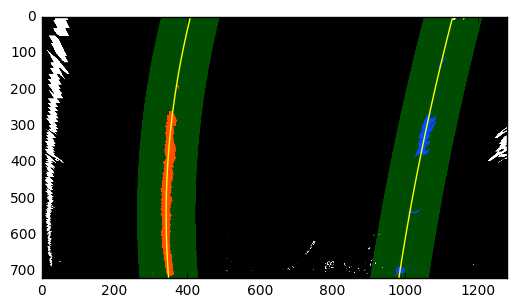

In [11]:
left_fit, right_fit = compute_left_and_right_fit(binary_warped, None, None, True, True)

## 6 Compute Radius of Curvature and Offset from Lane Center ##

** Radius of Curvature **
We need to compute the radius of curvature for these lane lines not on pixel values but converting the x and y values to real-world measurements (in meters) on x, y values. These x,y values are first computed on the basis of the polynomial fit functions with the appropriate metre-scaling function applied. Then the curvature fit cofficients are recomputed and the proscribed Radius of Curvature computed for each of the left and right curves. The overall radius of curvature will be the average of the left and right radius of curvature.

** Offset from Lane Center **
The offset from lane center is computed by taking difference of the mid-point of lane-lines from the mid-point of the images. Note that the lane-lines are the corresponding x-values computed at y_max based on the fit-polynomials.

In [12]:
def compute_curvature(binary_warped, left_fit, right_fit):

    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[
                     1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[
                      1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])

    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad


def compute_car_offset_from_center(img, left_lane_pixel, right_lane_pixel):

    xm_per_pix = 3.7 / 700  # meteres per pixel in x dimension
    screen_middle_pixel = img.shape[1] / 2
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel) / 2)
    pixels_off_center = screen_middle_pixel - car_middle_pixel
    meters_off_center = xm_per_pix * pixels_off_center
    return meters_off_center

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position. ##

In our function build_result_image we then map the detected lane lines, computed radius of curvature and offset from center will be overlayed on the original undistorted image as shown below :


In [13]:
def build_result_image(warped, undist, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    yvals = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * yvals**2 + left_fit[1] * yvals + left_fit[2]
    right_fitx = right_fit[0] * yvals**2 + right_fit[1] * yvals + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array(
        [np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective
    # matrix (Minv)
    newwarp = cv2.warpPerspective(
        color_warp, Minv, (undist.shape[1], undist.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    plt.imshow(result)
    left_curverad, right_curverad = compute_curvature(
        warped, left_fit, right_fit)
    avg_curverad = int((left_curverad + right_curverad) / 2)

    y_max = warped.shape[0]
    left_lane_pixel = left_fit[0] * y_max**2 + \
        left_fit[1] * y_max + left_fit[2]
    right_lane_pixel = right_fit[0] * y_max**2 + \
        right_fit[1] * y_max + right_fit[2]

    offset_from_center = compute_car_offset_from_center(
        warped, left_lane_pixel, right_lane_pixel)

    # Add text to plot
    text = "Radius of Curvature = {} m,\n Offset = {:.2f} m".format(
        avg_curverad, offset_from_center)
    plt.text(600, 100, text, horizontalalignment='center',
             verticalalignment='center', color='white')

    # Return result image
    return result, left_curverad, right_curverad, offset_from_center


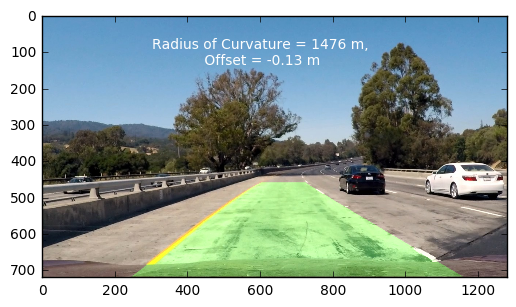

In [14]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
binary_warped = pre_process_image(img, M, mtx, dist)
left_fit, right_fit = compute_left_and_right_fit(binary_warped, None, None, True, False)
result = build_result_image(binary_warped, img, left_fit, right_fit, Minv)

## Keep track of measurements from frame to frame ##

As per the assignment's recommendation we will use Line class to track the Left and Right line objects to keep track of all the interesting parameters you measure from frame to frame.


In [15]:
class Line():

    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None

Left = Line()
Right = Line()

## 8 and 9 Process each frame of the video and apply proper smoothing

Our process_image function that applies the image pre_processing, line-fitting and output overlay is presented below. This function is invoked on each frame of the video to produce our final output video. In addition we 

** Apply smoothing across frames **

We apply a smoothing function to avoid jumping of lanes from frame to frame. Once we have a high-confidence fit, we average over the past n measurements to find the x-values over which we will drawn the lane curves. This is a simple first-order filter which multiplies alpha with last x-values and sums with (1 - alpha) x (current x-values) to produce a smoothing effect.

** Reject measurements/fit of frame if the following conditions do not hold ** 
1. Sufficient number of x-points are not detected to warrant a polynomial fit.


In [16]:
def process_image(img):
    
    alpha = 0.8

    # Pre-process the image to get an undistored, thresholded, binary, perspective
    # transformed image
    binary_warped = pre_process_image(img, M, mtx, dist)

    # Fit left and right lines
    if (Left.detected == False) or (Right.detected == False):
        Left.current_fit, Right.current_fit = compute_left_and_right_fit(
            binary_warped)
    else:
        Left.current_fit, Right.current_fit = compute_left_and_right_fit(binary_warped,
                                                                         Left.best_fit, Right.best_fit,
                                                                         False, False)

    # Smooth and process lines
    #
    
    yvals = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    # Process left line
    if Left.current_fit != None:
    
        if Left.best_fit == None:
            Left.best_fit = Left.current_fit
        
        # Smooth the xvals over previous fit and current-fit
        current_leftx = Left.current_fit[
            0] * yvals**2 + Left.current_fit[1] * yvals + Left.current_fit[2]
        last_leftx = Left.best_fit[0] * yvals**2 + \
            Left.best_fit[1] * yvals + Left.best_fit[2] 
            
        # Update the x based on the moving average
        leftx = (alpha*last_leftx) + (1 - alpha)*current_leftx
        
        # Recompute the best fit coefficients
        Left.best_fit = np.polyfit(yvals, leftx, 2)
        
        # Found left lane
        Left.detected = True
    else:
        Left.detected = False

    # Process right line
    if Right.current_fit != None:
        
        if Right.best_fit == None:
            Right.best_fit = Right.current_fit
            
        # Smooth the xvals over previous fit and current-fit   
        current_rightx = Right.current_fit[
            0] * yvals**2 + Right.current_fit[1] * yvals + Right.current_fit[2]
        last_rightx = Right.best_fit[0] * yvals**2 + \
            Right.best_fit[1] * yvals + Right.best_fit[2]
            
        # Update the x based on the moving average
        rightx = (alpha*last_rightx) + (1 - alpha)*current_rightx
        
        # Recompute the best fit coefficients
        Right.best_fit = np.polyfit(yvals, rightx, 2)
        
        # Found Right line
        Right.detected = True
    else:
        Right.detected = False

    # Compute curvature, draw lane boundaries and warp back to orignial image
    result, Left.radius_of_curvature, Right.radius_of_curvature, offset_from_center = build_result_image(
        binary_warped,
        img,
        Left.best_fit,
        Right.best_fit,
        Minv)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius_of_curvature + Right.radius_of_curvature) / 2)), (120, 140),
                fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    # Print distance from center on video
    if offset_from_center < 0:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(abs(offset_from_center)), (100, 80),
                    fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(offset_from_center), (100, 80),
                    fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    # Return result image
    return result

[MoviePy] >>>> Building video result_project_out.mp4
[MoviePy] Writing video result_project_out.mp4


100%|█████████▉| 1260/1261 [02:35<00:00,  8.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_project_out.mp4 

CPU times: user 5min 3s, sys: 11.8 s, total: 5min 15s
Wall time: 2min 35s


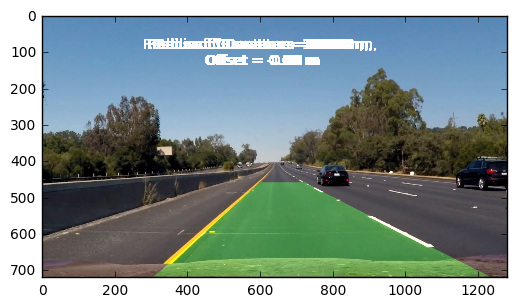

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import imageio
imageio.plugins.ffmpeg.download()

lane_output = 'result_project_out.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(lane_output, audio=False)

## Final Video Output of Project Video ##

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_output))


## Steps to improve this project ##

1. **Improved Color Thresholding to pick solid yellow and white lane markers and discard vertical dark lines** :  I followed the instructions from the class to use the S component of HSL and the recommended threshold parameteres and it worked well on four of the five test images. However in the challenge video the dark straight line of concrete barrier and the mid-lane dark ridges obfuscated the detection of the yellow lines. I will need to investigate if explicit Yellow and White masks can be applied on the images for the color thresholding piece and then or it with the vertical gradient threshold. 
2. **Filter out car horizontal lines** There has to be a way to remove the horizontal car images from vertical lane detection. 
3. **Deal with Double Solid Yellow Lines** In the more challenging video there were double solid yellow lines. The lane detection has to be updated to deal with these two close parallel lines followed by the white line. 
4 **More Robust Rejection Criteria** Reject if 
a) the two lines detected are too close to each other, 
b) if the curve fit coefficients magnitudes experience a sudden jump from frame to frame. This has to be done with careful thought. Some of the coefficients are much larger than the others in the expression. So simple norm checking from frame to frame might not accurately reflect the jump in relative change of the cofficients. I proposed taking a diff of the different fit coefficients and for each of three coefficients compute relative change in magnitude - if any differ by a significant % say 30% we drop the new coefficients.
c) We already drop the frame's fit measurements if sufficient curve points are not detected.
5. **Synthesize with Deep Learning/CNN Curve Fitting** The forums present a CNN approach to lane-detection. Maybe the detected images and the neural-network proposed lines could be over-laid and evaluated to figure out the actual lines.
